# Systems Modeling from scratch

I recently finished Donella H. Meadow's "Thinking in Systems," a primer on systems modeling. The book shows how phenomena like ecosystems, economies, business inventory, and room temperature can be modeled as a system where *stocks* of resources change at rates based on *flows* that depend on *information*. Understanding the structure will reveal reinforcing and balancing feedback loops and nonlinearities, and can provide strategies for changing systems.

One part of the book is about interesting and counterintuitive behavior that appears when running simulations for systems with certain structures. I wanted to try exploring some of these. 
The systems Meadows discuss are a graph with computations. As that lends itself to code, I wrote a [250-line simulator](https://github.com/jessstringham/notebooks/blob/master/scripts/model_simulation.py).

This post shows using the script to implement three example systems from the book. 
The systems and equations are transcribed from the book's appendix, and more complex equations are made up to match the graphs.


## Defining a system


Before diving into the example systems, this section describes how my script's `Components` map to those in [System Dynamics](https://en.wikipedia.org/wiki/System_dynamics). It then shows how a `Component` is defined and running the simulation.

### Components

I tried to code [`system_simulation.py`](https://github.com/jessstringham/notebooks/blob/master/scripts/model_simulation.py) to mostly match how Meadows describes systems.


Two components of the system are stocks (`StockComponent`), which remember how much of something there is, and flows (`FlowComponent`), which measure the rate of change of the stocks. 

An example of a system with stocks and flows is a bathtub: The stock is the amount of water in a bathtub. The inflow is the rate at which the faucet pours water into the bathtub. The outflow is the rate at which the water leaves the bathtub through the drain. The total amount of water in the bathtub is 


$$\text{the initial amount of water} + \text{amount of time} \times (\text{inflow rate} - \text{outflow rate})$$

In these systems, stocks cannot change except through flows. The flow can change depending on a `StockComponent` or a third component, the `InfoComponent`, which represents how information travels between stocks, flows, and other intermediate information components. (In the appendix, Meadows calls `InfoComponent`s Converters.)




### Defining a system


If the `room_temperature` depends on `heat_from_furnace` and `heat_from_outside`, and has an initial value of 10 degrees Celsius, I can define a stock with code like this:

```python
StockComponent(
    'room_temperature',
    initial_value=10,
    inflow='heat_from_furnace',
    outflow='heat_to_outside',
    min_value=-273.15
)
```

Then I'd need to define the inflow and outflow. The `FlowComponents` can define an equation for the flow, which takes the current timestep `t` and an argument for each of the `parents` in order. 

```python
FlowComponent(
    'heat_from_furnace',
    lambda t, thermostat_discrepancy: min(thermostat_discrepancy, 5),
    initial_value=0,
    parents=[Parent('thermostat_discrepancy')]
)

FlowComponent(
    'heat_to_outside',
    lambda t, outdoor_discrepancy: outdoor_discrepancy * .1,
    initial_value=0,
    parents=[Parent('outdoor_discrepancy')]
)
```

The rest of the connections are called `InfoComponents`, which look the same way as `FlowComponents`.



#### Other features

 - Normally the equations are passed the most recent value of the parent. To encode things like delays, `Parent(..., with_history=True)` will pass the equation the entire history of that component.
 - Loops are one of the most interesting parts of systems. But computations need to be done sequentially. To encode a feedback loop, `Parent(..., prev_timestep=True)`, will tell the equation to read the value computed at the previous timestep. `StockComponent` by default use the in- and outflows computed in the previous timestep.


### Simulation

After defining the network, I run the simulations for some number of steps. 

```
samples_per_hour = 2
hours = 100

t_num = hours * samples_per_hour
dt = 1/samples_per_hour

simulation = s.simulate(t_num, dt)
```

The above code would simulate 8 hours at a granularity of 30 minutes. It does so by computing values at 16 timesteps using a step size of 0.5 hours.

The simulation runs by computing each node for each timestep. `simulation` contains the values of each node over the timesteps.


In [1]:
import matplotlib.pyplot as plt
import pygraphviz as pgv
import numpy as np

from scripts.model_simulation import *


# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")


def plot_single_component(ax, simulation, component, t_num, dt):
    ax.plot(np.linspace(0, t_num * dt, t_num), simulation[component], label=component)
    ax.set_xlim(0, t_num * dt)
    ax.set_xlabel('time')
    ax.set_ylabel(component)


def edges_from_system(system):
    return [
        (parent, node)
        for node, parents in system.tree().items()
        for parent in parents
    ]


def plot_network(system, savefile, scale=10):
    G = pgv.AGraph(directed=True,
                   overlap=False,
                   splines=True)
    
    label_for_graph = lambda x: x.replace('_', '\n') 
    
    # Extract stocks, inflows, and outflows
    stocks = []
    inflows = []
    outflows = []
    for component in system.components.values():
        if type(component).__name__ == 'StockComponent':
            stocks.append(component.name)
            inflows.append(component.inflow)
            outflows.append(component.outflow)

    stocks = list(map(label_for_graph, stocks))
    inflows = list(map(label_for_graph, inflows))
    outflows = list(map(label_for_graph, outflows))    
    
    skip_these = stocks + inflows + outflows
        
    defaults = dict(
        style='filled',
        shape='box',
        pin=True,
    )
        
    for i, stock in enumerate(stocks):
        pos = "{},{}!".format(0, i*4)
        G.add_node(
            stock, 
            pos=pos,
            fillcolor='orange',
            **defaults,
        )
    for i, inflow in enumerate(inflows):
        pos = "{},{}!".format(-scale, i*4)
        G.add_node(
            inflow, 
            pos=pos,
            fillcolor='darkseagreen2',
            **defaults,
        )
    for i, outflow in enumerate(outflows):
        pos = "{},{}!".format(scale, i*4)
        G.add_node(
            outflow, 
            pos=pos,
            fillcolor='lightblue',
            **defaults,
        )          
        
    # add all nodes
    for node in system.components:
        node = label_for_graph(node)
        if node in skip_these:
            continue
        
        G.add_node(node, color='lightgray')
        
        
    for nodes in edges_from_system(system):
        G.add_edge(*map(label_for_graph, nodes))
        
    fixed_nodes = stocks + inflows + outflows
    
    G.draw('images/' + savefile, prog='fdp')

## A few models

What follows are three models from the book "Thinking in Systems." 
If you'd like to know more about the structure, equations, and resulting behavior, the book describes each system in detail in Chapter 2.

### System 1: Thermostat

The Thermostat system represents a room on a cold day. A furnace warms the room and heat leaks from the room.

In [2]:
s = System([
    
    # Stock: The temperature of the room
    StockComponent(
        'room_temperature',
        initial_value=10,
        inflow='heat_from_furnace',
        outflow='heat_to_outside',
        min_value=-273.15
    ),
    
    # Inflow: A furnace that warms the room
    FlowComponent(
        'heat_from_furnace',
        lambda t, thermostat_discrepancy: min(thermostat_discrepancy, 5),
        initial_value=0,
        parents=[Parent('thermostat_discrepancy')]
    ),
    # Outflow: The room leaks some heat
    FlowComponent(
        'heat_to_outside',
        lambda t, outdoor_discrepancy: outdoor_discrepancy * .1,
        initial_value=0,
        parents=[Parent('outdoor_discrepancy')]
    ),
    
    # Information: A thermostat that controls the furnace based on the room temperature.
    
    # target temperature for the thermostat
    InfoComponent(
        'thermostat_setting',
        lambda t: 18
    ),
    # weather outside
    InfoComponent(
        'outdoor_temperature',
        lambda t: 10
    ),
    
    # difference between the `room_temperature` and `thermostat_setting`
    InfoComponent(
        'thermostat_discrepancy',
        lambda t, thermostat_setting, room_temperature: max(0, thermostat_setting - room_temperature),
        parents=[Parent('thermostat_setting'), Parent('room_temperature')]
    ),
    # difference between the `room_temperature` and `outdoor_temperature`
    InfoComponent(
        'outdoor_discrepancy',
        lambda t, room_temperature, outdoor_temperature: (room_temperature - outdoor_temperature),
        parents=[Parent('room_temperature'), Parent('outdoor_temperature')]
    ),
    
])

# How often does thermostat change temperature
samples_per_hour = 2
t_num = 8 * samples_per_hour
dt = 1/samples_per_hour

### Network

The thermostat system has two balancing (negative) feedback loops.

In [3]:
# helper functions you can skip over :D
plot_network(s, '2019-07-01-thermostat_system.png', scale=1)

![](images/2019-07-01-thermostat_system.png)

### Simulation

The results of the simulation are shown below. The room gradually warms up to just below the thermostat setting.

In [4]:
simulation = s.simulate(t_num, dt)

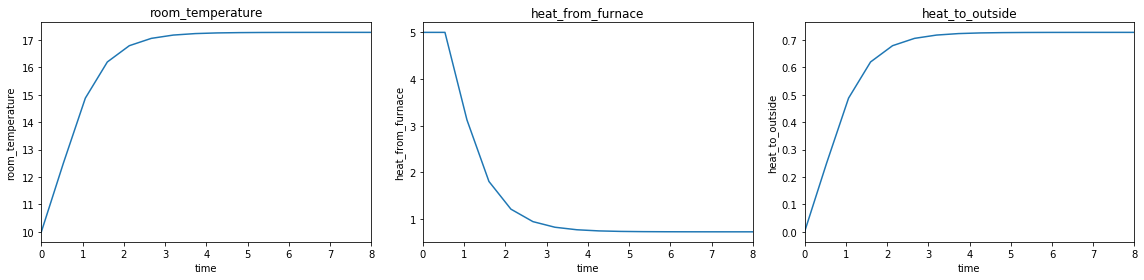

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plot_single_component(axs[0], simulation, 'room_temperature', t_num, dt)
axs[0].set_title('room_temperature')

plot_single_component(axs[1], simulation, 'heat_from_furnace', t_num, dt)
axs[1].set_title('heat_from_furnace')

plot_single_component(axs[2], simulation, 'heat_to_outside', t_num, dt)
axs[2].set_title('heat_to_outside')

maybe_save_plot('2019-07-01-temperatures')

### System 2: Inventory with delays

The next system models the inventory of a business after an increase in customer demand. This system has a similar structure to the room temperature system, except that delays are introduced. 

 - The **delivery delay** means that it takes a few days for *orders* to become *deliveries*. 
 - Because *sales* may have random noise, it's important to soften reactions to them. This **perception delay** means that the *perceived sales* (which *orders* depend on) is the average of *actual sales* over a few timesteps.
 - The **response delay** controls how quickly to try to make up the *discrepancy* between desired and actual inventory.

In [6]:
def delays_inventory(perception_delay=0, response_delay=0, delivery_delay=0):
    return System([
        
        StockComponent(
            'inventory',
            initial_value=200,
            inflow='deliveries',
            outflow='sales',
            min_value=0
        ),
        
        # Inflow: deliveries. They are eventually adjusted based on new orders to factory
        FlowComponent(
            'deliveries',
            lambda t, orders_to_factory, delivery_delay: (
                20 if t < delivery_delay else (
                    orders_to_factory[-int(delivery_delay + 1)]
                )
            ),
            initial_value=20,
            parents=[Parent('orders_to_factory', with_history=True), Parent('delivery_delay')]
        ),
        
        # Outflow: sales 
        FlowComponent(
            'sales',
            lambda t, inventory, customer_demand: min(inventory, customer_demand),
            initial_value=20,
            parents=[Parent('inventory'), Parent('customer_demand')]
        ),
        
        
        InfoComponent(
            'customer_demand',
            lambda t: 20 if t <= 25 else 22,
            initial_value=20,
        ),
        InfoComponent(
            'perceived_sales',
            lambda t, sales, perception_delay: (
                sum(sales[-int(min(t, perception_delay) + 1):])/(min(t, perception_delay) + 1)
            ),
            parents=[Parent('sales', with_history=True), Parent('perception_delay')]
        ),
        InfoComponent(
            'desired_inventory',
            lambda t, perceived_sales: perceived_sales * 10,
            parents=[Parent('perceived_sales')]
        ),
        InfoComponent(
            'discrepancy',
            lambda t, desired_inventory, inventory: desired_inventory - inventory,
            parents=[Parent('desired_inventory'), Parent('inventory')]
        ),
        InfoComponent(
            'orders_to_factory',
            lambda t, perceived_sales, discrepancy, response_delay: (
                max(0, perceived_sales + (
                    discrepancy if response_delay == 0 else discrepancy/response_delay)
                )
            ),
            parents=[Parent('perceived_sales'), Parent('discrepancy'), Parent('response_delay')],
            initial_value=20,
        ),  
        
        # Delays
        InfoComponent(
            'perception_delay',
            lambda t: perception_delay,
            initial_value=perception_delay,
        ),
        InfoComponent(
            'response_delay',
            lambda t: response_delay,
            initial_value=response_delay,
        ),    
        InfoComponent(
            'delivery_delay',
            lambda t: delivery_delay,
            initial_value=delivery_delay,
        ),      
    ])

samples_per_day = 1
days = 100
t_num = days * samples_per_day
dt = 1/samples_per_day

### Network

The inventory system also has one stock (inventory) and two balancing feedback loops. 

In [7]:
# helper functions you can skip over :D
plot_network(delays_inventory(), '2019-07-01-delays_system.png', scale=1)

![](images/2019-07-01-delays_system.png)

#### Simulation with no delays

In the case of no delays, the inventory quickly adjusts in response to the change in customer demand.

The red line shows when the customer demand changed.

In [8]:
s = delays_inventory(
    perception_delay=0,
    response_delay=0,
    delivery_delay=0,
)
simulation = s.simulate(t_num, dt)

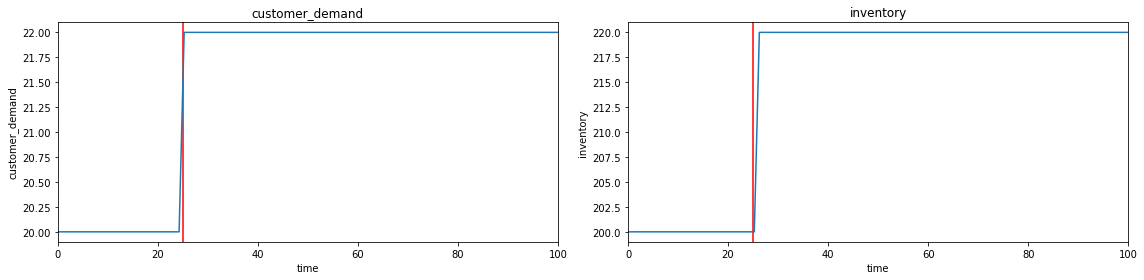

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].axvline(25, color='r')
plot_single_component(axs[0], simulation, 'customer_demand', t_num, dt)
axs[0].set_title('customer_demand')

axs[1].axvline(25, color='r')
plot_single_component(axs[1], simulation, 'inventory', t_num, dt)
axs[1].set_title('inventory')

maybe_save_plot('2019-07-01-no-delay')

### Simulation with delays

When delays are introduced, wild oscillations happen in response to a small change in demand. 

In [10]:
s = delays_inventory(
    perception_delay=5,
    response_delay=3,
    delivery_delay=5,
)
simulation = s.simulate(t_num, dt)

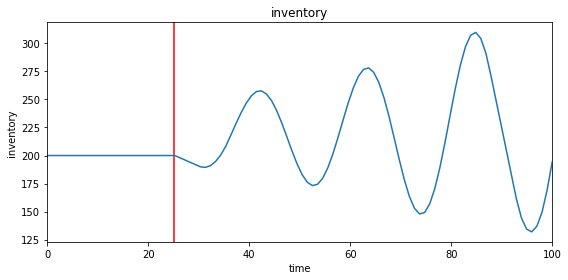

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axvline(25, color='r')
plot_single_component(ax, simulation, 'inventory', t_num, dt)
ax.set_title('inventory')

maybe_save_plot('2019-07-01-delay')

### Simulation with different response delays

The first reaction may be that "delay is bad, reduce all the delay". The delivery delay is outside of our control, and the perception delay is a good idea to account for noise. But counterintuitively, reducing the response delay results in larger oscillations! Instead, *increasing* the response delay will lead to a smoother reaction.

In [12]:
s = delays_inventory(
    perception_delay=5,
    response_delay=2,
    delivery_delay=5,
)
simulation_fast = s.simulate(t_num, dt)

s = delays_inventory(
    perception_delay=5,
    response_delay=6,
    delivery_delay=5,
)
simulation_slow = s.simulate(t_num, dt)

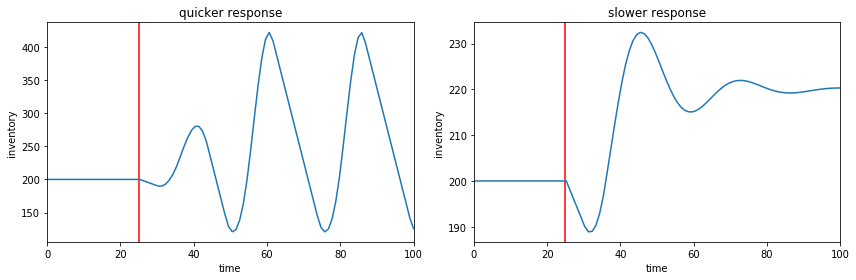

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].axvline(25, color='r')
plot_single_component(axs[0], simulation_fast, 'inventory', t_num, dt)
axs[0].set_title('quicker response')

axs[1].axvline(25, color='r')
plot_single_component(axs[1], simulation_slow, 'inventory', t_num, dt)
axs[1].set_title('slower response')

maybe_save_plot('2019-07-01-response-time')

### System 3: Renewable Resource

The renewable resource system is a more complicated system from the book.

There are two stocks:
 - the renewable resource of fish (stock), which regenerate (inflow) and are harvested (outflow)
 - the capital used to catch more fish (stock), which grows with investment (inflow), and depreciates (outflow)

In addition, there are many other connections which introduce feedback loops. For example, there is a reinforcing feedback loop of capital, which creates more investment which increases capital and so on.


#### Aside, some helper functions

The appendix of the book plots a few magical functions. I tried to approximate them below.

First is `regeneration_rate_given_resource`, that gives some optimal regeneration rate location. If there are too few fish, they can't find each other. If there are too many fish, they fight over food.

In [14]:
# In this model, fish regenerate slower if there aren't many other fish, or if there are too many other fish.
def regeneration_rate_given_resource(resource):
    scaled_resource = (resource/1000)
    
    if scaled_resource < 0.5:
        adjusted_resource = scaled_resource
    else:
        adjusted_resource = (1 - scaled_resource)
        
    rate = np.tanh(12 * adjusted_resource - 3)
    rate = (rate + 1)/4
    return max(0, rate)

# People require fish, and are willing to pay more for fish if it is scarce.
def price_given_yield_per_unit_capital(yield_per_unit_capital):
    return 8.8 * np.exp(-yield_per_unit_capital*4) + 1.2

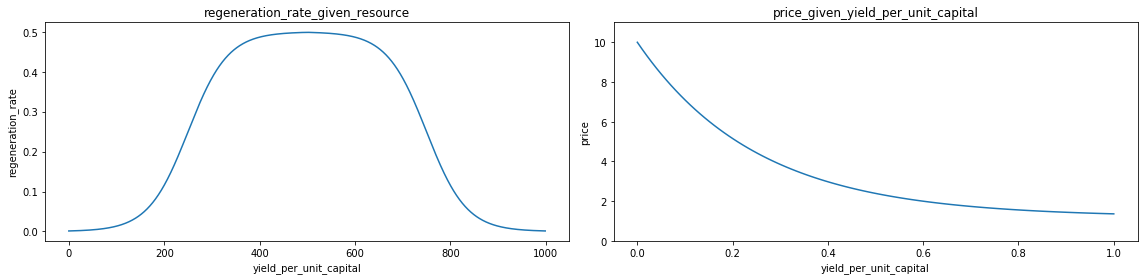

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

xs = range(1000)
y = list(map(regeneration_rate_given_resource, xs))
axs[0].set_title('regeneration_rate_given_resource')
axs[0].set_xlabel('yield_per_unit_capital')
axs[0].set_ylabel('regeneration_rate')
axs[0].plot(xs, y)

xs = np.linspace(0, 1, 100)
y = list(map(price_given_yield_per_unit_capital, xs))
axs[1].set_title('price_given_yield_per_unit_capital')
axs[1].set_xlabel('yield_per_unit_capital')
axs[1].set_ylabel('price')
axs[1].set_ylim(0, 11)
axs[1].plot(xs, y)

maybe_save_plot('2019-07-01-renewable-equations')

The third function `yield_per_unit_capital_given_resource`, turns out to be the most important this example.

The example given in the book is how much money it takes to get the same number of fish. Moving the location of the curve to the right might represent boats that can go into deeper water and catch more fish with the same amount of capital.

The book shows how different curves result in different scenerios. I admit I don't know the theory behind it, so I just call the parameter `some_measure_of_efficiency`, which shifts the curve to the left or right.

In [16]:
def yield_per_unit_capital_given_resource(resource, some_measure_of_efficiency):
    return min(1, max(0, (np.tanh(resource/1000*6 - 3 + some_measure_of_efficiency))/1.9 + 0.5))

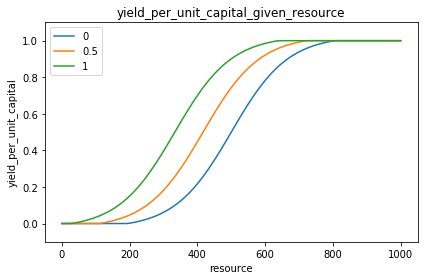

In [17]:
xs = np.linspace(0, 1000, 100)

for i, some_measure_of_efficiency in enumerate([0, 0.5, 1]):
    y = [yield_per_unit_capital_given_resource(x, some_measure_of_efficiency) for x in xs]
    plt.plot(xs, y, label=some_measure_of_efficiency)

plt.xlabel('resource')
plt.ylabel('yield_per_unit_capital')
plt.ylim(-.1, 1.1)
plt.title('yield_per_unit_capital_given_resource')
plt.legend()

maybe_save_plot('2019-07-01-yield-per-unit')

In [18]:
def renewable_resource(some_measure_of_efficiency):
    return System([
        StockComponent(
            name='resource',
            initial_value=1000,
            inflow='regeneration',
            outflow='harvest',
            min_value=0,
        ),
        FlowComponent(
            name='regeneration',
            initial_value=0,
            equation=lambda t, resource, regeneration_rate: resource * regeneration_rate,
            parents=[Parent('resource'), Parent('regeneration_rate')]
        ),
        FlowComponent(
            name='harvest',
            initial_value=0, 
            equation=lambda t, resource, capital, yield_per_unit_capital: min(resource, capital * yield_per_unit_capital),
            parents=[Parent('resource'), Parent('capital', prev_timestep=True), Parent('yield_per_unit_capital')]
        ),
        
        StockComponent(
            name='capital',
            initial_value=5,
            inflow='investment',
            outflow='depreciation',
            min_value=0,
        ),
        FlowComponent(
            name='investment',
            equation=lambda t, profit, growth_goal: max(0, min(profit, growth_goal)),
            initial_value=0,
            parents=[Parent('profit'), Parent('growth_goal')]
        ),
        FlowComponent(
            name='depreciation',
            equation=lambda t, capital, capital_lifetime: capital/capital_lifetime,
            initial_value=0,
            parents=[Parent('capital', prev_timestep=True), Parent('capital_lifetime')]
        ),    
        
        InfoComponent(
            name='capital_lifetime', 
            equation=lambda _: 20),
        
        InfoComponent(
            name='growth_goal',
            equation=lambda t, capital: capital * .1,
            parents=[Parent('capital', prev_timestep=True)]),
        
        InfoComponent(
            name='profit',
            equation=lambda t, price, harvest, capital: (price * harvest) - capital,
            parents=[Parent('price'), Parent('harvest'), Parent('capital', prev_timestep=True)]
        ),
        InfoComponent(
            name='price',
            equation=lambda t, yield_per_unit_capital: price_given_yield_per_unit_capital(yield_per_unit_capital),
            parents=[Parent('yield_per_unit_capital')]
        ),
        InfoComponent(
            name='regeneration_rate',
            equation=lambda t, resource: regeneration_rate_given_resource(resource),
            parents=[Parent('resource')]),
        InfoComponent(
            name='yield_per_unit_capital',
            equation=lambda t, resource: yield_per_unit_capital_given_resource(resource, some_measure_of_efficiency),
            parents=[Parent('resource')]
        )
    ])
    
years = 200
samples_per_year = 1
t_num = years * samples_per_year
dt = 1/samples_per_year

### Network

In [19]:
# helper functions you can skip over :D
plot_network(renewable_resource(1), '2019-07-01-renewable_resource.png', scale=1)

![](images/2019-07-01-renewable_resource.png)

### Simulation: Overfishing

If they are too good at catching fish, the number of fish drops to nearly 0.

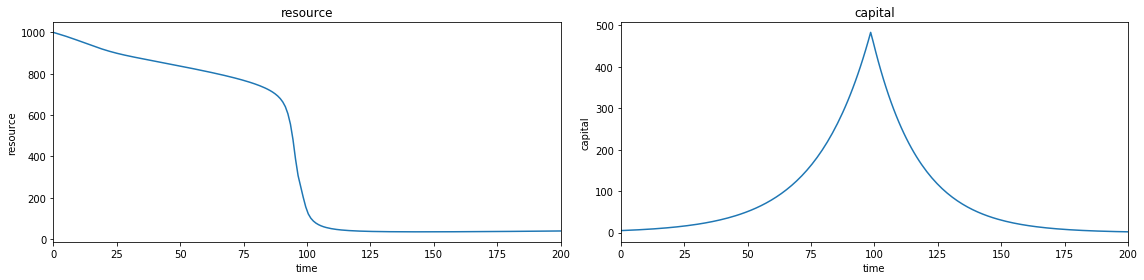

In [20]:
s = renewable_resource(1)
simulation = s.simulate(t_num, dt)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_single_component(axs[0], simulation, 'resource', t_num, dt)
axs[0].set_title('resource')

plot_single_component(axs[1], simulation, 'capital', t_num, dt)
axs[1].set_title('capital')

maybe_save_plot('2019-07-01-overfishing')

### Simulation: Equal out

If they are a little worse at catching fish, the number of fish stabilizes.

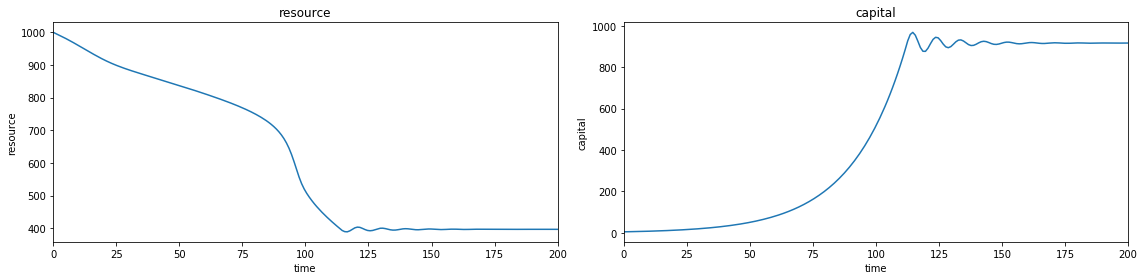

In [21]:
s = renewable_resource(0)
simulation = s.simulate(t_num, dt)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_single_component(axs[0], simulation, 'resource', t_num, dt)
axs[0].set_title('resource')

plot_single_component(axs[1], simulation, 'capital', t_num, dt)
axs[1].set_title('capital')

maybe_save_plot('2019-07-01-overfishing-equal')

#### Aside: Fun plots

If instead of plotting resource and capital over time, I plot resource and capital, it shows a cool spiral as the values approach an [attractor](https://en.wikipedia.org/wiki/Attractor).

In [22]:
def compare_simulation_values(x_value, y_value, zoom=True):
    plot_num = 2 if zoom else 1
    fig, axs = plt.subplots(1, plot_num, figsize=(8 * plot_num, 4))
    if plot_num == 1:
        axs = [axs]
    for ax in axs:
        ax.plot(simulation[x_value], simulation[y_value])
        ax.set_xlabel(x_value)
        ax.set_ylabel(y_value)
    return axs

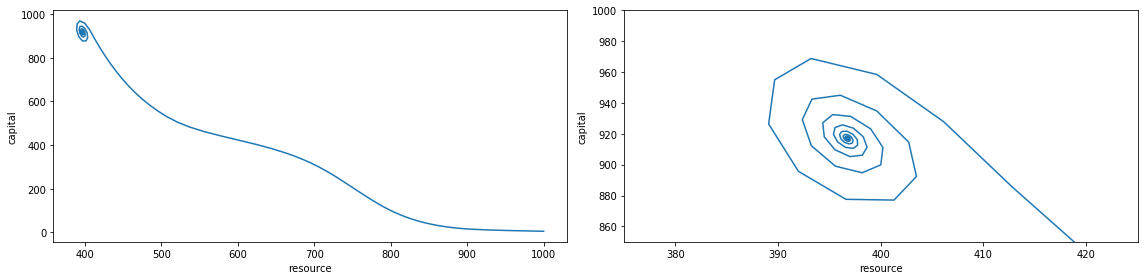

In [23]:
axs = compare_simulation_values('resource', 'capital')
axs[1].set_xlim(375, 425)
axs[1].set_ylim(850, 1000)
maybe_save_plot('2019-07-01-spiral')

### Simulation: Oscillations forever

If they are even worse at catching fish, the number of fish oscillates.

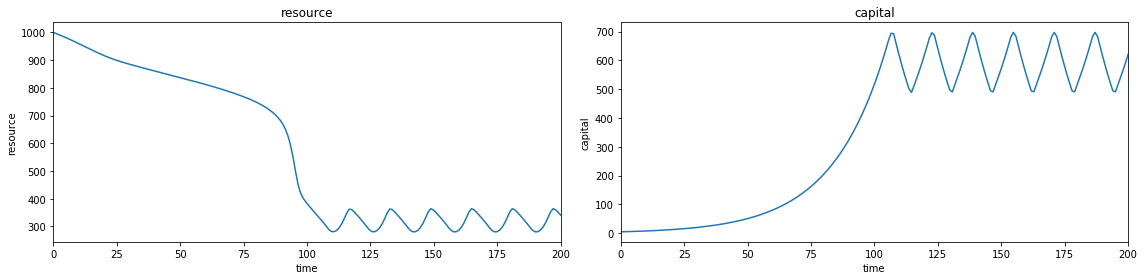

In [24]:
s = renewable_resource(0.5)
simulation = s.simulate(t_num, dt)

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
plot_single_component(axs[0], simulation, 'resource', t_num, dt)
axs[0].set_title('resource')

plot_single_component(axs[1], simulation, 'capital', t_num, dt)
axs[1].set_title('capital')

plt.tight_layout()
maybe_save_plot('2019-07-01-overfishing-oscillations')

#### Aside: Fun plots

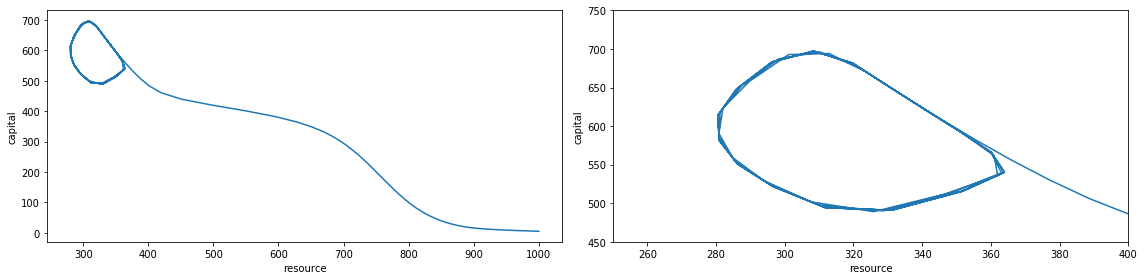

In [25]:
axs = compare_simulation_values('resource', 'capital')
axs[1].set_xlim(250, 400)
axs[1].set_ylim(450, 750)

maybe_save_plot('2019-07-01-overfishing-oscillations-spiral')

## Conclusion

This post gave a quick tour of interesting behavior from some systems based on the example models from "Thinking in Systems" using a quick implementation [`system_simulation.py`](https://github.com/jessstringham/notebooks/blob/master/scripts/model_simulation.py).
Some additional places of the web that might be interesting:
 - [Thinking in Systems](https://www.chelseagreen.com/product/thinking-in-systems/)
 - Wikipedia on [System dynamics](https://en.wikipedia.org/wiki/System_dynamics)
 - For pro software for modeling system dynamics, there's [MATLAB's Simulink](https://en.wikipedia.org/wiki/Simulink)